# Design Single Country Nat Cat Bonds

In [41]:
#import general packages
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import haz_storm as hst
import exposures as ex
import grider as grd
import impact as cimp
import bound_prot_dam as bpd
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as nom
client = Client()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Perform natural hazard simulation 
### Define variables for cat bonds

In [2]:
#choose storm basin to load
#The STORM basins are: 'EP','NA','NI','SI','SP','WP'
basins = ['SI']

#choose country
country = 174

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
upper_rp = 200
lower_rp = 100

### Load TC Tracks for basin

currently not needed because I incorporated it into the ex.init_TC_exp function -> still coudnt figure out how to load exisitng tc track files -> it takes forever without throwing an error

In [3]:
#storms_basin = hst.init_STORM_tracks(basins=basins, load_fls=False)

### Generate Exposure Data and TC hazards impacting selected exposure
1. Generate exposure data using newest available data. Can choose fin_mode myself, reference year, and resolution. <br>
2. Generate centroids at the locations of the exposed assets <br>
3. Filter tc tracks so that dataset only includes tracks which affect chosen exposure locations <br>
4. Generate tc hazards


STORM basin of country:  SI
----------------------Loading Exposure----------------------
----------------------Loading Hazard----------------------


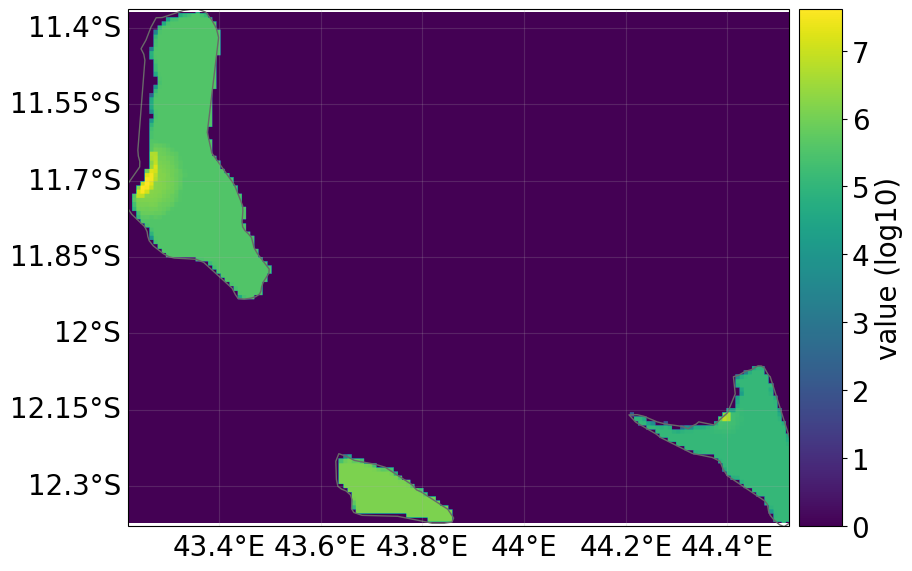

In [4]:
exp, applicable_basins, storm_basin_sub, tc_storms = ex.init_TC_exp(basins, country, load_fls=True)

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:93: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


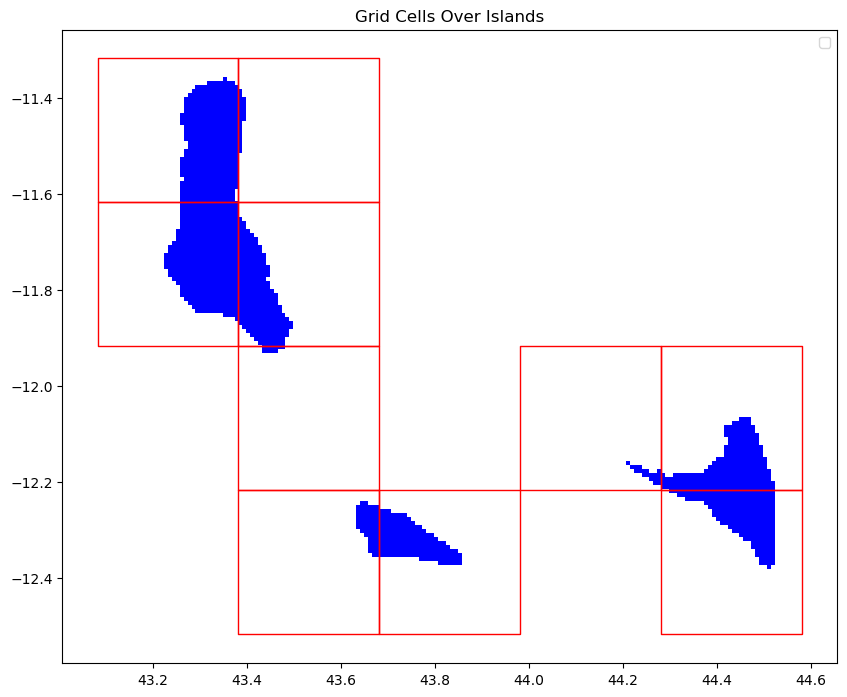

In [5]:
rst_grid = grd.init_grid(exp)

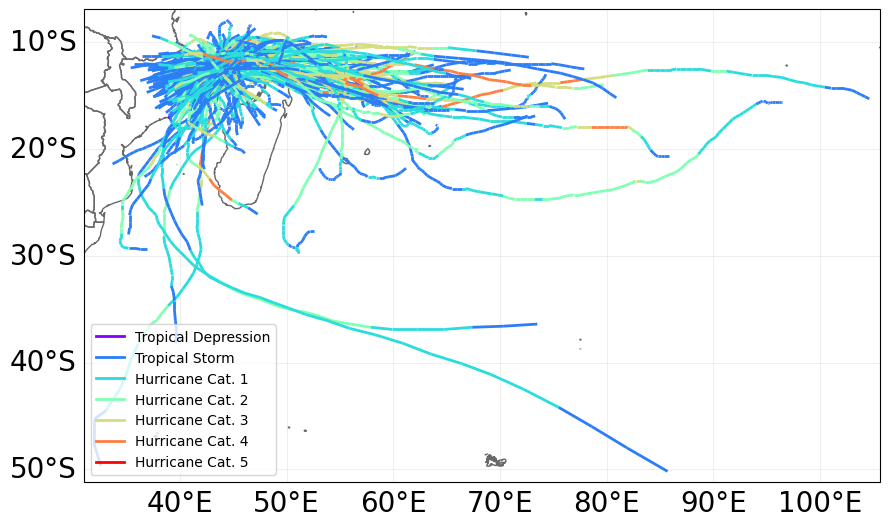

In [6]:
#plot filtered tc hazards
ax_sub = storm_basin_sub.plot()
ax_sub.get_legend()._loc = 3

### Calculate Impact
1. Calculate impact matrix
2. Determine exposure points per grid cell
3. Calculate total impacts per grid cell and event

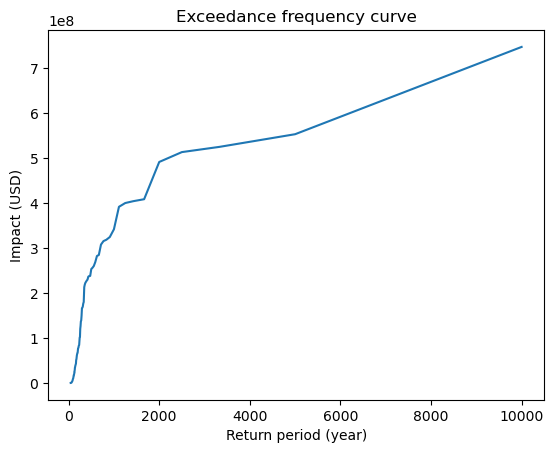

In [7]:
imp, imp_per_exp, agg_exp, imp_grid_evt = cimp.init_imp(exp, tc_storms, rst_grid) 

## Optimize insurance policies

### Asses hazard intensity per event and grid cell
Creation of data frame which indicates the sustained wind speed per event and grid cell caclualted using max, mean or median statistic across hazard centroid located in each grid cell.

In [35]:
ws_grid = hig.init_ws_grid(tc_storms, agg_exp, 'max')

### Set boundarys for protected damage
1. Calculate damage return periods for grid cells
2. Set minimum damage which should be protected per grid cell
3. Adjust damage per grid and event dictionary. Damage below minimum damage should be zero. Optionally we can also set the maximum damage to the nominal, but the default is not to.

when it goes to pooling the available nominal increases so also the upper payout limit increases

Go the other way around and say cover damages with max x% of e.g. GDP


#### Set the nominal
Can be set in diferent ways:
1. Protecting a specified percentage of e.g. GDP
2. Protecting damages of specified return period

In [42]:
#define nominal
nominal, tot_exp, nom_rel_exp = nom.init_nominal(impact=imp)

The principal of the cat bond is: 68281241.57656431


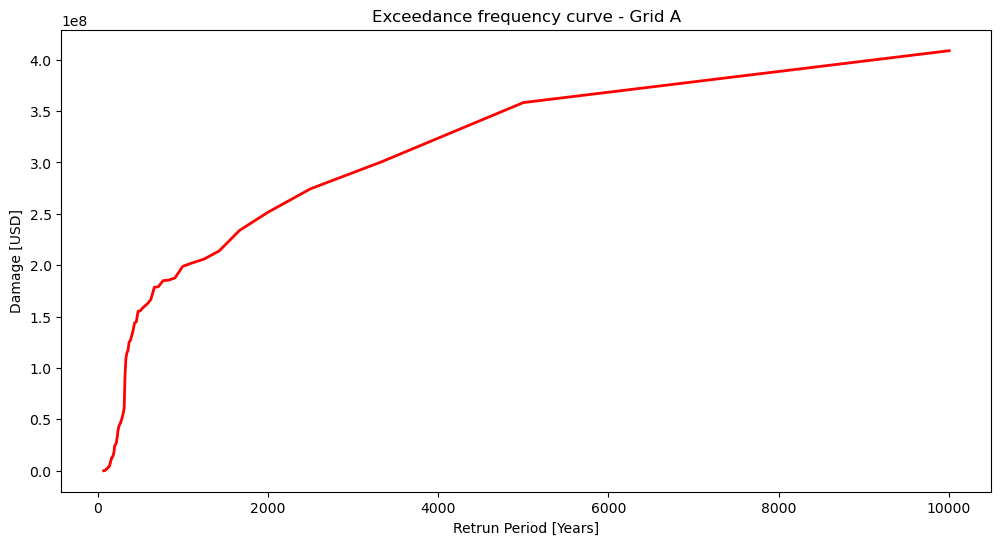

In [38]:
rp_dam_grid, dam_rp_per_grid, imp_grid_evt_flt = bpd.init_dam_ret_per_grid(imp_grid_evt, lower_rp, nominal, adj_max=False, plt_dam_rp_grid='A')

### Define objective function

In [12]:
def slope(x, y, min_pay, max_pay):
    m = (max_pay - min_pay) / (y - x)
    return m

def intercept(nominal, m, y):
    b = nominal - (m * y)
    return b

def calculate_payout(x, y, haz_int, max_min_pay, grid):
    payout_df = pd.DataFrame(index=np.arange(len(haz_int)), columns=np.arange(1))
    for i in range(len(haz_int)):
        filtered_rows = pd.DataFrame(max_min_pay.iloc[grid]) #Filter rows where 'Grid' has the value 'grid'
        max_pay = nominal
        min_pay = filtered_rows.loc['Lower'].iloc[0]
        m = slope(x, y, min_pay, max_pay)
        b = intercept(max_pay, m, y)
        wind_speed = haz_int.iloc[i, grid]

        if x <= wind_speed <= y:
            payout = m * wind_speed + b
        elif wind_speed > y:
            payout = max_pay
        else:
            payout = 0

        payout_df.iloc[i,0] = payout

    return payout_df

def objective_function(params, damage_matrix):
    """Objective function to minimize.
    
    Parameters
    ----------
    params : list
        List of parameters [x, y] for each grid cell.
    damage_matrix : np.ndarray
        Matrix of damage values.
        
    Returns
    -------
    float
        Sum of squared differences between calculated payout and damage.
    """
    num_cells = damage_matrix.shape[1]  #Number of grid cells
    total_diff = 0

    #Extract parameters for each grid cell
    for cell_idx in range(num_cells):
        x = params[cell_idx * 2]      #minimum wind speed
        y = params[cell_idx * 2 + 1]  #maximum wind speed
        
        #Compute payouts
        payouts = calculate_payout(x, y, ws_grid, rp_dam_grid, cell_idx)
        
        #Compute the difference between payout and damage
        diff = np.sum(((payouts.iloc[:, 0] - damage_matrix.iloc[:, cell_idx]) ** 2)** 0.5)
        total_diff += diff

    return total_diff

### Perform optimization

In [13]:
from scipy.optimize import minimize

#Initial guess for parameters
sequence = [30, 40]
length = 20
initial_params = np.tile(sequence, length // len(sequence))

#Define bounds for minimum and maximum wind speeds
bounds = [(25, 39) if i % 2 == 0 else (40, 200) for i in range(len(initial_params))]


#Perform optimization
result = minimize(
    fun=objective_function,
    x0=initial_params,
    args=(imp_grid_evt_flt,), 
    method='L-BFGS-B',  #How to choose optimization method?
    bounds=bounds  
)

#Extract the optimized parameters
optimized_params = result.x
print("Optimized parameters:", optimized_params)

print('Missmatch between payment and damage:',result.fun)

#Reshape parameters into a more interpretable form if needed
optimized_xs = optimized_params[0::2]  #minimum threshold of windspeeds
optimized_ys = optimized_params[1::2]  #maximum threshold of windspeeds

Optimized parameters: [ 32.0570236   43.01077739  35.204113    67.91809092  34.47003821
  57.12548882  39.         200.          34.96206751  76.48294602
  34.42932071  50.37105268  39.         200.          39.
 200.          34.71402888 105.64339217  36.48764951 125.49352213]
Missmatch between payment and damage: 5595254487.016019


### Create payout vs damage matrix per event
Plot it on 1:1 scale

In [14]:
payout_evt_grd = {letter: [None] * len(tc_storms.event_id) for letter in agg_exp.keys()}
payout_evt_grd = pd.DataFrame(payout_evt_grd)
pay_dam_df = pd.DataFrame({'pay': [0] * len(tc_storms.event_id), 'damage': [0] * len(tc_storms.event_id)})

for i in range(len(imp_grid_evt_flt)):
    tot_dam = np.sum(imp_grid_evt_flt.iloc[i, :])
    pay_dam_df.loc[i,"damage"] = tot_dam
    for j in range(len(ws_grid.columns)):
        tot_payout = calculate_payout(optimized_xs[j], optimized_ys[j], ws_grid, rp_dam_grid, j)
        payout_evt_grd.iloc[:,j] = tot_payout.iloc[:,0]
    tot_pay = np.sum(payout_evt_grd.iloc[i, :])
    if tot_pay > nominal:
            tot_pay = nominal
    else: 
        pass
    pay_dam_df.loc[i,"pay"] = tot_pay

C:\Users\kaibe\AppData\Local\Temp\ipykernel_23064\2570711157.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '408293461.3343402' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pay_dam_df.loc[i,"damage"] = tot_dam
C:\Users\kaibe\AppData\Local\Temp\ipykernel_23064\2570711157.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '68281241.57656431' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pay_dam_df.loc[i,"pay"] = tot_pay


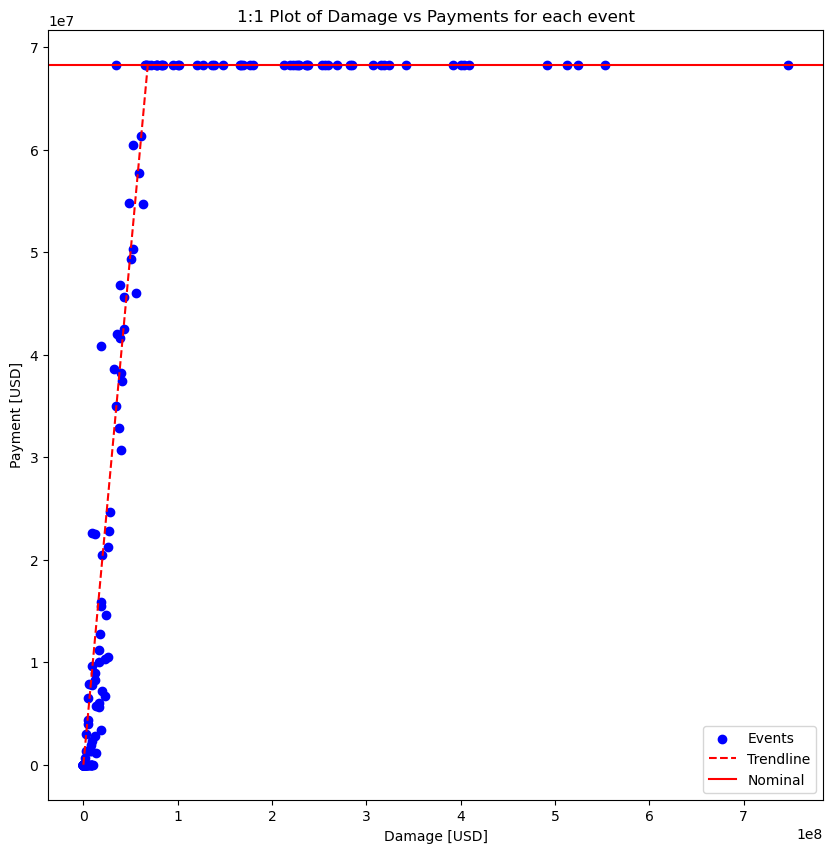

In [15]:
#Create a 1:1 plot (scatter plot with equal scales)
plt.figure(figsize=(10, 10)) 
plt.scatter(pay_dam_df['damage'], pay_dam_df['pay'], color='blue', marker='o', label='Events')

# Add a 1:1 line for reference
plt.plot([pay_dam_df['pay'].min(), pay_dam_df['pay'].max()], [pay_dam_df['pay'].min(), pay_dam_df['pay'].max()], color='red', linestyle='--', label='Trendline')

#plot horizontal line at nominal
plt.axhline(y = nominal, color = 'r', linestyle = '-', label='Nominal') 

plt.xlabel('Damage [USD]')
plt.ylabel('Payment [USD]')
plt.title('1:1 Plot of Damage vs Payments for each event')
plt.legend()
plt.show()

### Set up premium calculation function

R² = 0.640603377049146


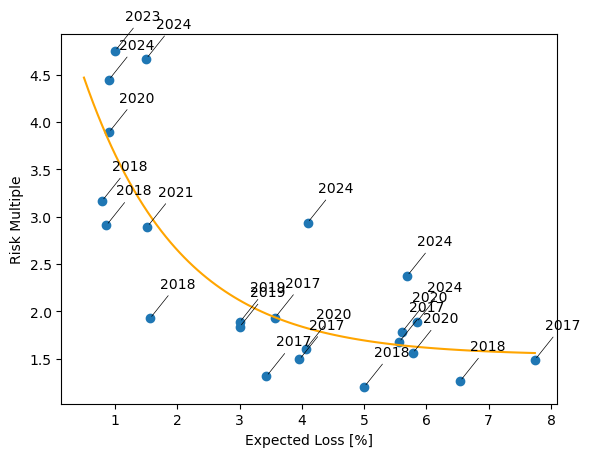

In [33]:
params_ibrd = prib.init_prem_ibrd()

### Calculate cat bond metrics
1. Perform Monte-Carlo Simulation
2. Calculate Metrics
    - Expected Loss
    - Attachment Probability
    - Value at risk
    - Coverage
    - Basis-Risk
    - Expected Shortfall

In [18]:
""" #transform payouts to numpy array
payouts = pay_dam_df['pay'].to_numpy()
damages = pay_dam_df['damage'].to_numpy()

#Parameters for the Monte Carlo Simulation
num_simulations = 10000  # Number of Monte Carlo iterations
simulated_losses = []
simulated_damages = []
event_probability = len(payouts) / r

#Monte Carlo Simulation
for _ in range(num_simulations):
    #randomly generate number of events in one year using poisson distribution and calculated yearly event probability
    num_events = np.random.poisson(lam=event_probability)
    #If there are events in the year, sample that many payouts and the associated damages
    if num_events > 0:
        random_indices = np.random.randint(0, len(payouts), size=num_events)
        simulated_payouts = payouts[random_indices]
        selected_damages = damages[random_indices]
        total_damage = np.sum(selected_damages)
        total_loss = np.sum(simulated_payouts)
        if total_loss > nominal:
            total_loss = nominal
        else: 
            pass
    else:
        total_loss = 0
        total_damage = 0  #No events, no loss damage

    simulated_losses.append(total_loss)
    simulated_damages.append(total_damage)

# Convert simulated losses to a DataFrame
simulated_losses = pd.Series(simulated_losses)
simulated_damages = pd.Series(simulated_damages) """

" #transform payouts to numpy array\npayouts = pay_dam_df['pay'].to_numpy()\ndamages = pay_dam_df['damage'].to_numpy()\n\n#Parameters for the Monte Carlo Simulation\nnum_simulations = 10000  # Number of Monte Carlo iterations\nsimulated_losses = []\nsimulated_damages = []\nevent_probability = len(payouts) / r\n\n#Monte Carlo Simulation\nfor _ in range(num_simulations):\n    #randomly generate number of events in one year using poisson distribution and calculated yearly event probability\n    num_events = np.random.poisson(lam=event_probability)\n    #If there are events in the year, sample that many payouts and the associated damages\n    if num_events > 0:\n        random_indices = np.random.randint(0, len(payouts), size=num_events)\n        simulated_payouts = payouts[random_indices]\n        selected_damages = damages[random_indices]\n        total_damage = np.sum(selected_damages)\n        total_loss = np.sum(simulated_payouts)\n        if total_loss > nominal:\n            total_l

In [19]:
""" #Expected Loss
exp_loss_hist = pay_dam_df['pay'].sum() / r
exp_loss_sim = simulated_losses.mean()

rel_exp_loss_hist = exp_loss_hist / nominal
rel_exp_loss_sim = exp_loss_sim / nominal

print(f"Expected Loss (historic): {exp_loss_hist}")
print(f"Expected Loss (simulation): {exp_loss_sim}")

print(f"Relative Expected Loss (historic): {rel_exp_loss_hist}")
print(f"Relative Expected Loss (simulation): {rel_exp_loss_sim}")

#Attachment Probability
att_prob_hist = (pay_dam_df['pay'] > 0).sum() / r
att_prob_sim = (simulated_losses > 0).sum() / num_simulations

print(f"Attachment Probability (historic): {att_prob_hist}")
print(f"Attachment Probability (simulation): {att_prob_sim}")

#Coverage
cov_hist = pay_dam_df['pay'].sum() / pay_dam_df['damage'].sum()
cov_sim = sum(simulated_losses) / sum(simulated_damages)

print(f"Coverage (historic): {cov_hist}")
print(f"Coverage (simulation): {cov_sim}")

#Basis Risk
ba_ri_hist = (pay_dam_df['damage'].sum() - pay_dam_df['pay'].sum()) / len(payouts)
ba_ri_sim = (sum(simulated_damages) - sum(simulated_losses)) /len(payouts)

print(f"Basis-Risk (historic): {ba_ri_hist}")
print(f"Basis-Risk (simulation): {ba_ri_sim}")

#Value at Risk
VaR_95 = simulated_losses.quantile(0.95)
VaR_99 = simulated_losses.quantile(0.99)

print(f"Value at Risk (95% confidence): {VaR_95}")
print(f"Value at Risk (99% confidence): {VaR_99}")

#Expected shortfall
ES_95 = simulated_losses[simulated_losses > VaR_95].mean()
ES_99 = simulated_losses[simulated_losses > VaR_99].mean()

print(f"Expected Shortfall (95% confidence): {ES_95}")
print(f"Relative Expected Shortfall (95% confidence): {ES_95 / nominal}")
 """

' #Expected Loss\nexp_loss_hist = pay_dam_df[\'pay\'].sum() / r\nexp_loss_sim = simulated_losses.mean()\n\nrel_exp_loss_hist = exp_loss_hist / nominal\nrel_exp_loss_sim = exp_loss_sim / nominal\n\nprint(f"Expected Loss (historic): {exp_loss_hist}")\nprint(f"Expected Loss (simulation): {exp_loss_sim}")\n\nprint(f"Relative Expected Loss (historic): {rel_exp_loss_hist}")\nprint(f"Relative Expected Loss (simulation): {rel_exp_loss_sim}")\n\n#Attachment Probability\natt_prob_hist = (pay_dam_df[\'pay\'] > 0).sum() / r\natt_prob_sim = (simulated_losses > 0).sum() / num_simulations\n\nprint(f"Attachment Probability (historic): {att_prob_hist}")\nprint(f"Attachment Probability (simulation): {att_prob_sim}")\n\n#Coverage\ncov_hist = pay_dam_df[\'pay\'].sum() / pay_dam_df[\'damage\'].sum()\ncov_sim = sum(simulated_losses) / sum(simulated_damages)\n\nprint(f"Coverage (historic): {cov_hist}")\nprint(f"Coverage (simulation): {cov_sim}")\n\n#Basis Risk\nba_ri_hist = (pay_dam_df[\'damage\'].sum() - pa

In [152]:
term = 3

def init_sharpe_ratio(rel_returns, risk_free_rate):
    std = np.std(rel_returns)
    exp_ret = np.mean(rel_returns)
    rf = np.mean(risk_free_rate)
    sharpe_ratio = (exp_ret - rf) / std
    return sharpe_ratio

def init_coverage(payouts, damages):
    if np.sum(payouts) == np.sum(damages) == 0:
        coverage = np.nan
        basis_risk = np.nan
        tot_pay = np.nan
    elif np.sum(payouts) == 0: 
        coverage = 0
        basis_risk = -np.sum(damages)
        tot_pay = np.nan
    else:
        coverage = np.sum(payouts) / np.sum(damages)
        basis_risk = np.sum(payouts) - np.sum(damages)
        tot_pay = np.sum(payouts)

    return coverage, basis_risk, tot_pay

def init_expected_loss(returns):
    #Filter to get the returns that are negative -> losses
    losses = returns.apply(lambda x: 0 if x > 0 else x)
    loss_magnitudes = -losses
    expected_loss = np.mean(loss_magnitudes)
    return expected_loss

def init_model_rf(risk_free_rate):

    modeled_rf_rates = [risk_free_rate] * term

    return modeled_rf_rates

def check_rf(risk_free_rates, iterator):

    if isinstance(risk_free_rates, list):
        rf = risk_free_rates[iterator]
    else:
        rf = risk_free_rates

    return rf

def init_bond(payouts, damages, premium, risk_free_rates, nominal, event_probability):

    simulated_ncf = []
    tot_payout = []
    tot_damage = []
    rf_rates_list = []
    payout_count = 0
    metrics = {}    
    cur_nominal = nominal
    payout_happened = False

    for i in range(term):
        rf = check_rf(risk_free_rates, i)
        rf_rates_list.append(rf)
        net_cash_flow = 0
        #randomly generate number of events in one year using poisson distribution and calculated yearly event probability
        num_events = np.random.poisson(lam=event_probability)
        #If there are events in the year, sample that many payouts and the associated damages
        if num_events == 0 and not payout_happened or cur_nominal == 0:
            net_cash_flow = cur_nominal * (premium + rf)
            sum_damages = 0
            sum_payouts = 0
        elif num_events > 0:
            random_indices = np.random.randint(0, len(payouts), size=num_events)
            sum_payouts = np.sum(payouts[random_indices])
            sum_damages = np.sum(damages[random_indices])
            if sum_payouts == 0 and not payout_happened:
                net_cash_flow = cur_nominal * (premium + rf)
            elif sum_payouts > 0:
                net_cash_flow = 0 - sum_payouts
                cur_nominal += net_cash_flow
                payout_count += 1
                payout_happened = True
                if cur_nominal < 0:
                    net_cash_flow = (cur_nominal - net_cash_flow) * -1
                    sum_payouts = sum_payouts - cur_nominal
                    cur_nominal = 0
                else:
                    pass
            

        simulated_ncf.append(net_cash_flow)
        tot_payout.append(sum_payouts)
        tot_damage.append(sum_damages)
    simulated_ncf_rel = simulated_ncf / nominal
    coverage, basis_risk, tot_pay = init_coverage(tot_payout, tot_damage)
    metrics['coverage'] = coverage
    metrics['basis_risk'] = basis_risk
    metrics['att_prob'] = payout_count / term
    metrics['tot_pay'] = tot_pay

    return simulated_ncf_rel, metrics, rf_rates_list


### Simulate a 3-year cat bond

In [153]:
rf_rates = 0.05

# Parameters for the Monte Carlo Simulation
term = 3 #time until maturation of bond
tot_simulated_ncf = []
metric_names = ['att_prob', 'coverage', 'basis_risk', 'tot_pay']

premiums = np.arange(0.00, 0.11, 0.01)

want_ann_returns = True

#transform payouts to numpy array
payouts = pay_dam_df['pay'].to_numpy()
damages = pay_dam_df['damage'].to_numpy()

event_probability = len(payouts) / r
num_simulations = 20000  # Number of Monte Carlo iterations



def init_bond_simulation(premiums, rf_rates, want_ann_returns=True, model_rf=False):
    # Check if premiums is a single value
    if np.isscalar(premiums):
        premiums = np.array([premiums])

    if np.isscalar(rf_rates):
        rf_rates = np.array([rf_rates])

    returns_rf = {}
    metrics_rf = {}

    for rf_iter in rf_rates:
        rf_str = str(rf_iter)
        #model interest rates when wanted
        if model_rf:
            rf_iter = init_model_rf(rf_iter)
        else:
            pass

        metrics_per_premium = pd.DataFrame(index = range(len(premiums)), columns=["Premium", "Sharpe_ratio_ann","VaR_01_ann", "ES_01_ann", "Attachment_probability_ann", "Annual_expected_loss",
                                                                              "Sharpe_ratio_tot","VaR_01_tot", "ES_01_tot", "Attachment_probability_bond", "Bond_expected_loss",
                                                                                "Coverage", "Basis_risk", "Average Payments"])
    
        returns_per_premium = pd.DataFrame(index = range(len(premiums)), columns=["Premium","Annual", "Total"])

        for i, premium in enumerate(premiums):
            #Monte Carlo Simulation
            annual_returns = []
            tot_returns = []
            rf_annual = []
            rf_total = []
            metrics_sim = {key: [] for key in metric_names}
            for _ in range(num_simulations):
                simulated_ncf_rel, metrics, rf_rates_list = init_bond(payouts, damages, premium, rf_iter, nominal, event_probability)
        
                metrics_sim['att_prob'].append(metrics['att_prob'])
                metrics_sim['coverage'].append(metrics['coverage'])
                metrics_sim['basis_risk'].append(metrics['basis_risk'])
                metrics_sim['tot_pay'].append(metrics['tot_pay'])
    
                if want_ann_returns:
                    ann_return = np.mean(simulated_ncf_rel)
                else:
                    ann_return = (1 + sum(simulated_ncf_rel)) ** (1/term) - 1
                
                annual_returns.append(ann_return)
                tot_returns.append(np.sum(simulated_ncf_rel))
                rf_annual.append(np.mean(rf_rates_list))
                rf_total.append(np.sum(rf_rates_list))
    
            # Convert simulated net cash flows to a series
            annual_returns = pd.Series(annual_returns)
            tot_returns = pd.Series(tot_returns)
            #calculate finacial metrics
            metrics_sim_mean = {key: np.nanmean(values_sim) for key, values_sim in metrics_sim.items()}
            VaR_01_ann = annual_returns.quantile(0.01)
            VaR_01_tot = tot_returns.quantile(0.01)
            ES_01_ann = annual_returns[annual_returns < VaR_01_ann].mean()
            ES_01_tot = tot_returns[tot_returns < VaR_01_tot].mean()
            exp_loss_ann = init_expected_loss(annual_returns)
            exp_loss_tot = init_expected_loss(tot_returns)
            att_prob_tot =  sum(1 for value in metrics_sim['tot_pay'] if value > 0) / num_simulations
            premium_float = np.float64(premium)
    
            sharpe_ratio_ann = init_sharpe_ratio(annual_returns, rf_annual)
            sharpe_ratio_tot = init_sharpe_ratio(tot_returns, rf_total)
    
            metrics_per_premium.loc[i] = [premium_float, sharpe_ratio_ann, VaR_01_ann, ES_01_ann, metrics_sim_mean['att_prob'], exp_loss_ann,
                                          sharpe_ratio_tot, VaR_01_tot, ES_01_tot, att_prob_tot, exp_loss_tot, 
                                          metrics_sim_mean['coverage'], metrics_sim_mean['basis_risk'], metrics_sim_mean['tot_pay']]  
            
            returns_per_premium.loc[i] = [premium_float, annual_returns, tot_returns]

            
        returns_rf[rf_str] = returns_per_premium
        metrics_rf[rf_str] = metrics_per_premium

    return metrics_rf, returns_rf



In [154]:
premium_simulation, returns = init_bond_simulation(premiums, rf_rates)

In [87]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve


# Define the difference function between Sharpe ratio curve and required Sharpe ratio

def init_requ_premium(requ_sharpe_ratio, simulation_matrix, rf):

    premiums = simulation_matrix['Premium']
    sharpe_ratios = simulation_matrix['Sharpe_ratio_ann']

    # Interpolate the Sharpe ratio curve
    sharpe_interp = interp1d(premiums, sharpe_ratios, kind='linear')

    # Define the difference function between Sharpe ratio curve and required Sharpe ratio
    def intersection_func(x):
        return np.float64(sharpe_interp(x).item()) - requ_sharpe_ratio

    # Use fsolve to find the intersection point(s), provide a guess
    x_guess = 0.01  # Initial guess based on the range of premiums
    x_intersection = fsolve(intersection_func, x_guess)[0]

    # Calculate the corresponding Sharpe ratio at the intersection point
    y_intersection = sharpe_interp(x_intersection)

    print(f"Intersection point: Premium = {x_intersection:.4f}, Sharpe Ratio = {y_intersection:.4f}")

    return x_intersection

Intersection point: Premium = 0.0701, Sharpe Ratio = 1.0000


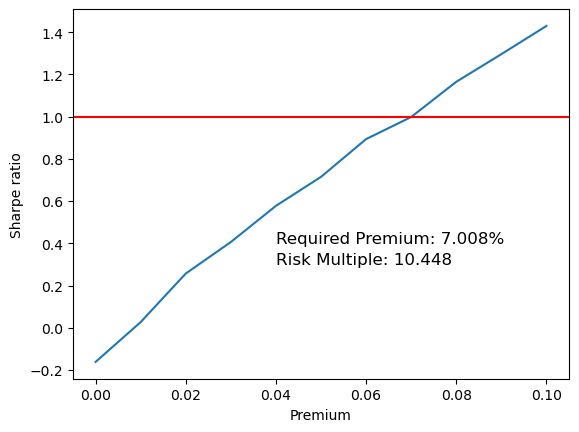

In [88]:
requ_premium = init_requ_premium(1.0, premium_simulation)
risk_multiple = requ_premium/premium_simulation['Annual_expected_loss'][1]

plt.plot(premium_simulation['Premium'], premium_simulation['Sharpe_ratio_ann'])
plt.axhline(y = 1.0, color = 'r', linestyle = '-', label='Required Sharpe Ratio') 
plt.text(0.04, 0.4, f'Required Premium: {round(requ_premium*100,3)}%', fontsize = 12)
plt.text(0.04, 0.3, f'Risk Multiple: {round(risk_multiple,3)}', fontsize = 12)
plt.xlabel('Premium')
plt.ylabel('Sharpe ratio')
plt.show()

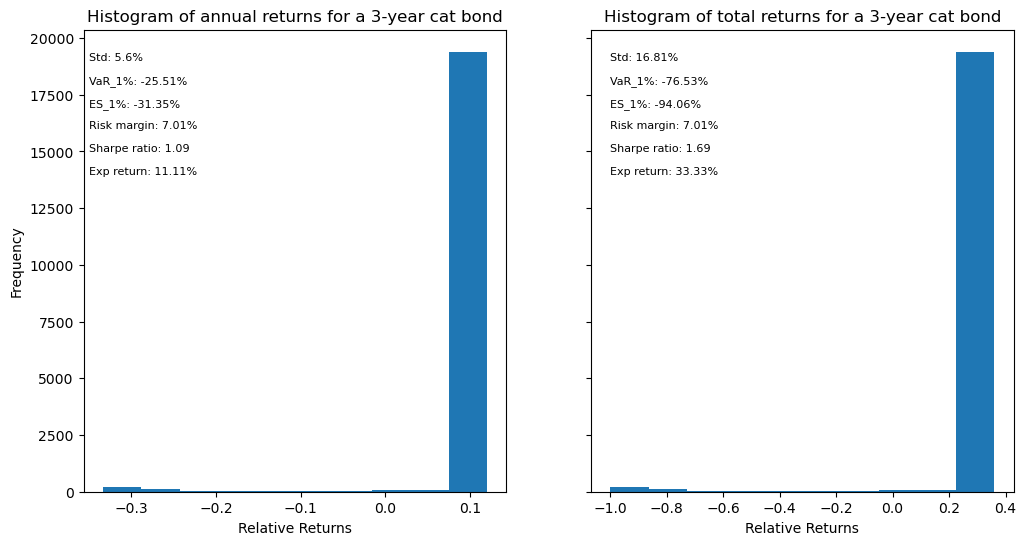

In [98]:
requ_premium_sim, requ_premium_annual_returns, requ_premium_tot_returns = init_bond_simulation(requ_premium)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax1.hist(requ_premium_annual_returns)
ax1.text(-0.35, num_simulations-1000, f'Std: {round(np.std(requ_premium_annual_returns)*100,2)}%', fontsize = 8)
ax1.text(-0.35, num_simulations-2000, f'VaR_1%: {round(requ_premium_sim["VaR_01_ann"][0]*100,2)}%', fontsize = 8)
ax1.text(-0.35, num_simulations-3000, f'ES_1%: {round(requ_premium_sim["ES_01_ann"][0]*100,2)}%', fontsize = 8)
ax1.text(-0.35, num_simulations-4000, f'Risk margin: {round(requ_premium_sim["Premium"][0]*100,2)}%', fontsize = 8)
ax1.text(-0.35, num_simulations-5000, f'Sharpe ratio: {round(requ_premium_sim["Sharpe_ratio_ann"][0],2)}', fontsize = 8)
ax1.text(-0.35, num_simulations-6000, f'Exp return: {round(np.mean(requ_premium_annual_returns)*100,2)}%', fontsize = 8)
ax1.set_xlabel('Relative Returns')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of annual returns for a 3-year cat bond')

ax2.hist(requ_premium_tot_returns)
ax2.text(-1.0, num_simulations-1000, f'Std: {round(np.std(requ_premium_tot_returns)*100,2)}%', fontsize = 8)
ax2.text(-1.0, num_simulations-2000, f'VaR_1%: {round(requ_premium_sim["VaR_01_tot"][0]*100,2)}%', fontsize = 8)
ax2.text(-1.0, num_simulations-3000, f'ES_1%: {round(requ_premium_sim["ES_01_tot"][0]*100,2)}%', fontsize = 8)
ax2.text(-1.0, num_simulations-4000, f'Risk margin: {round(requ_premium_sim["Premium"][0]*100,2)}%', fontsize = 8)
ax2.text(-1.0, num_simulations-5000, f'Sharpe ratio: {round(requ_premium_sim["Sharpe_ratio_tot"][0],2)}', fontsize = 8)
ax2.text(-1.0, num_simulations-6000, f'Exp return: {round(np.mean(requ_premium_tot_returns)*100,2)}%', fontsize = 8)
ax2.set_xlabel('Relative Returns')
#ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of total returns for a 3-year cat bond')

plt.show()


In [ ]:
""" #calculate premium
risk_multi = monoExp((rel_exp_loss_sim * 100), a, k, b)
p = rel_exp_loss_sim * risk_multi
print('The calculated risk spread is: ',p)
#risk free rate
rf = 0.05

annualized_returns = []
tot_simulated_ncf = []
for _ in range(num_simulations):
    simulated_ncf = []
    cur_nominal = nominal
    payout_happened = False
    for i in range(term):
        net_cash_flow = 0
        #randomly generate number of events in one year using poisson distribution and calculated yearly event probability
        num_events = np.random.poisson(lam=event_probability)
        #If there are events in the year, sample that many payouts and the associated damages
        if num_events == 0 and not payout_happened or cur_nominal == 0:
            net_cash_flow = cur_nominal * (p + rf)
        elif num_events > 0:
            random_indices = np.random.randint(0, len(payouts), size=num_events)
            simulated_payouts = payouts[random_indices]
            sum_simulated_payouts = np.sum(simulated_payouts)
            if sum_simulated_payouts == 0 and not payout_happened:
                net_cash_flow = cur_nominal * (p + rf)
            elif sum_simulated_payouts > 0:
                net_cash_flow = 0 - sum_simulated_payouts
                cur_nominal += net_cash_flow
                payout_happened = True
                if cur_nominal < 0:
                    net_cash_flow = (cur_nominal - net_cash_flow) * -1
                    cur_nominal = 0
                else:
                    pass
        simulated_ncf.append(net_cash_flow)
    ann_return = np.mean(simulated_ncf)
    annualized_returns.append(ann_return)
    tot_ncf = sum(simulated_ncf)
    tot_simulated_ncf.append(tot_ncf)

# Convert simulated net cash flows to a series
tot_simulated_ncf = pd.Series(tot_simulated_ncf)
VaR_99 = tot_simulated_ncf.quantile(0.01)
ES_99 = tot_simulated_ncf[tot_simulated_ncf < VaR_99].mean()
rel_simulated_ncf = tot_simulated_ncf / nominal

std_ncf = rel_simulated_ncf.std(0, ddof=0)
exp_ret = rel_simulated_ncf.mean()
sharpe_ratio = (exp_ret - rf) / std_ncf """

The calculated risk spread is:  0.02961721235048719


0.1644451727837437
-62844879.466408074
-68281241.57656431
0.9818742022759626


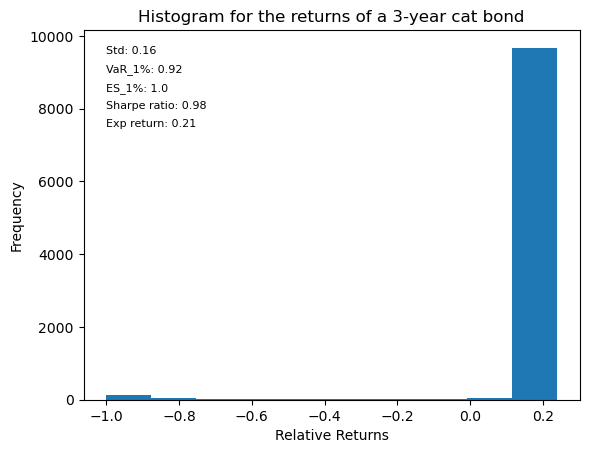

In [ ]:
""" print(std_ncf)
print(VaR_99)
print(ES_99)
print(sharpe_ratio)
plt.hist(rel_simulated_ncf)
plt.text(-1.0, 9500, f'Std: {round(std_ncf,2)}', fontsize = 8)
plt.text(-1.0, 9000, f'VaR_1%: {round(VaR_99/nominal*-1,2)}', fontsize = 8)
plt.text(-1.0, 8500, f'ES_1%: {round(ES_99/nominal*-1,2)}', fontsize = 8)
plt.text(-1.0, 8000, f'Sharpe ratio: {round(sharpe_ratio,2)}', fontsize = 8)
plt.text(-1.0, 7500, f'Exp return: {round(exp_ret,2)}', fontsize = 8)
plt.xlabel('Relative Returns')
plt.ylabel('Frequency')
plt.title('Histogram for the returns of a 3-year cat bond')
plt.show() """

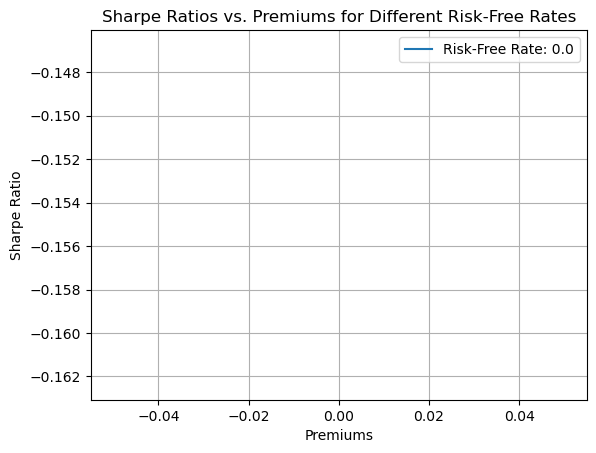

In [ ]:
""" for rf in np.nditer(rf_interest_rates):
    rf_str = str(rf)  
    if rf_str in sharpe_ratios_rf:
        plt.plot(premiums, sharpe_ratios_rf[rf_str], label=f'Risk-Free Rate: {rf_str}')

plt.xlabel('Premiums')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios vs. Premiums for Different Risk-Free Rates')
plt.legend()
plt.grid(True)
plt.show() """